In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from collections import defaultdict

In [2]:
absolute = pd.read_csv("stringtheory_citations_bibliometrics.csv", header=0)
absolute = absolute.apply(lambda x: x.iloc[1:])

absolute["Unnamed: 13"] = pd.to_numeric(absolute["Unnamed: 13"], errors='coerce').astype(float).astype(pd.Int32Dtype())
absolute = absolute[absolute["Unnamed: 13"].astype(int) > 0]

absolute.head()

,"About the data: Exported on Mar 24, 2024. Criteria: '""string theory""' in title and abstract. Note: For hyper-authorship publications with more than 100 authors the export does not include author names and affiliations. © 2024 Digital Science &amp; Research Solutions Inc. All rights reserved. Parts of this work may also be protected by copyright of content providers and other third parties, which together with all rights of Digital Science, user agrees not to violate. Redistribution / external use of this work (or parts thereof) is prohibited without prior written approval. Please contact info@dimensions.ai for further information.",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
1,pub.1044092489,10.1016/s0370-2693(98)00377-3,Gauge theory correlators from non-critical str...,We suggest a means of obtaining certain Green'...,Physics Letters B,1998,428,1-2,105-114,"Gubser, S.S.; Klebanov, I.R.; Polyakov, A.M.",Princeton University,United States,https://app.dimensions.ai/details/publication/...,7663,"[Gubser, Steven S.; Klebanov, Igor R.; Tseytli..."
2,pub.1042716891,10.1023/a:1026654312961,The Large-N Limit of Superconformal Field Theo...,We show that the large-N limits of certainconf...,International Journal of Theoretical Physics,1999,38,4,1113-1133,"Maldacena, Juan",NaN,NaN,https://app.dimensions.ai/details/publication/...,5586,"[Gunaydin, M; Marcus, N]|[ur.012256777135.62; ..."
3,pub.1022092215,10.1016/s0370-1573(99)00083-6,"Large N field theories, string theory and gravity",We review the holographic correspondence betwe...,Physics Reports,2000,323,3-4,183-386,"Aharony, Ofer; Gubser, Steven S.; Maldacena, J...",European Organization for Nuclear Research; Ha...,Switzerland; United States,https://app.dimensions.ai/details/publication/...,3844,"[Horowitz, Gary T.; Strominger, Andrew]|[ur.01..."
4,pub.1005284426,10.1016/s0370-2693(98)00860-0,New dimensions at a millimeter to a fermi and ...,"Recently, a new framework for solving the hier...",Physics Letters B,1998,436,3-4,257-263,"Antoniadis, Ignatios; Arkani-Hamed, Nima; Dimo...",Abdus Salam International Centre for Theoretic...,France; Italy; United States,https://app.dimensions.ai/details/publication/...,3485,"[Hořava, Petr; Witten, Edward]|[ur.0631440304...."
5,pub.1007113443,10.1088/1126-6708/1999/09/032,String theory and noncommutative geometry,We extend earlier ideas about the appearance o...,Journal of High Energy Physics,1999,1999,09,032,"Seiberg, Nathan; Witten, Edward",Institute for Advanced Study,United States,https://app.dimensions.ai/details/publication/...,3337,NaN


In [3]:
def convert_to_initials(name):
    if isinstance(name, str):
        author_names = name.split(';')
        converted_names = []
        for author_name in author_names:
            if ',' in author_name:
                parts = author_name.split(',')
                last_name = parts[0]
                first_names = parts[1].strip().split()
                first_initial = first_names[0][0] if first_names else ''  # Take only the first initial
                converted_names.append(last_name + ', ' + first_initial)
            elif ' ' in author_name:
                parts = author_name.split()
                last_name = parts[-1] + ', '
                first_initial = parts[0][0] if len(parts) > 1 else ''  # Take only the first initial
                converted_names.append(last_name + first_initial)
        return ';'.join(converted_names) if converted_names else None
    else:
        return None

def convert_authors_to_initials(df, column_name):
    df[column_name] = df[column_name].apply(convert_to_initials)
    df.dropna(subset=[column_name], inplace=True)  # Drop rows with None values
    return df

changedInitials = convert_authors_to_initials(absolute, "Unnamed: 9")

In [4]:
# make a structured array with number of citations per author (in the top 5000 works)
def parse_authors_and_citations(df):
    author_citations = defaultdict(int)

    for index, row in df.iterrows():
        authors = row["Unnamed: 9"].split('; ')
        citations = row["Unnamed: 13"]
        
        for author in authors:
            author = author.strip().replace(" ", "")  # Remove spaces from the author name
            author_citations[author] += int(citations)
    
    return author_citations

author_citations = parse_authors_and_citations(changedInitials)

author_citationNum = [(author, citation_count) for author, citation_count in author_citations.items()]

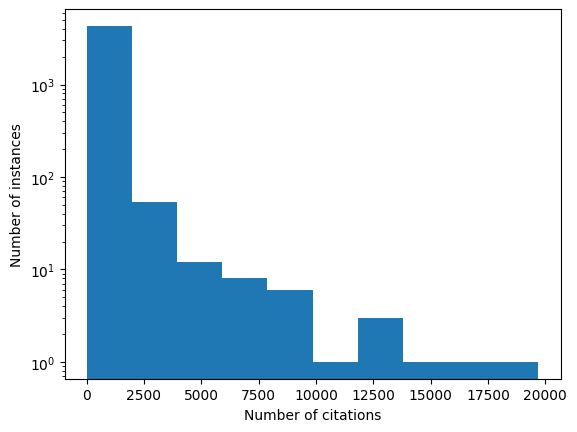

In [5]:
# histogram of citation number

citation_numbers = [citation_count for _, citation_count in author_citationNum]

plt.hist(citation_numbers)
plt.yscale('log')
plt.xlabel("Number of citations")
plt.ylabel("Number of instances")
plt.savefig("citations_distribution_strings.png")

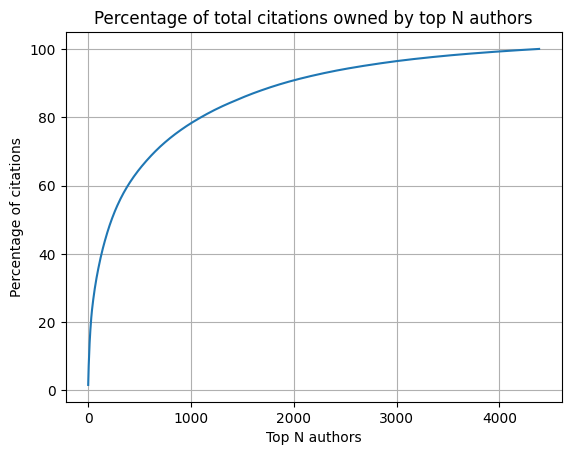

In [6]:
# make a plot of % of citations owned by x% of authors

def plot_top_authors_citations(structured_array, top_percentage):

    structured_array.sort(key=lambda x: x[1], reverse=True)  # Sort authors by citation count
    total_citations = sum(citation_count for _, citation_count in structured_array)
    
    cumulative_citations = 0
    citation_percentages = []
    authors_count = len(structured_array)
    top_authors_count = int(authors_count * top_percentage / 100)

    for i in range(top_authors_count):
        cumulative_citations += structured_array[i][1]
        citation_percentages.append(cumulative_citations / total_citations * 100)
    
    # Plotting
    plt.plot(range(1, top_authors_count + 1), citation_percentages)
    plt.xlabel('Top N authors')
    plt.ylabel('Percentage of citations')
    plt.title('Percentage of total citations owned by top N authors')
    plt.grid(True)
    plt.savefig("citations_owned_strings.png")
    plt.show()

plot_top_authors_citations(author_citationNum, 100)

In [7]:
absolute_cites = changedInitials["Unnamed: 13"]
absolute_year = changedInitials["Unnamed: 5"]
absolute_authors = changedInitials["Unnamed: 9"]

# numpy array of number of citations
abs_cite_arr = absolute_cites.iloc[1:].to_numpy(dtype=int)
year_arr = absolute_year.iloc[1:].to_numpy(dtype=int)

/tmp/ipykernel_95862/739129547.py:12: RuntimeWarning: invalid value encountered in true_divide
  avg_citations_per_year = total_citations_per_year / num_works_per_year


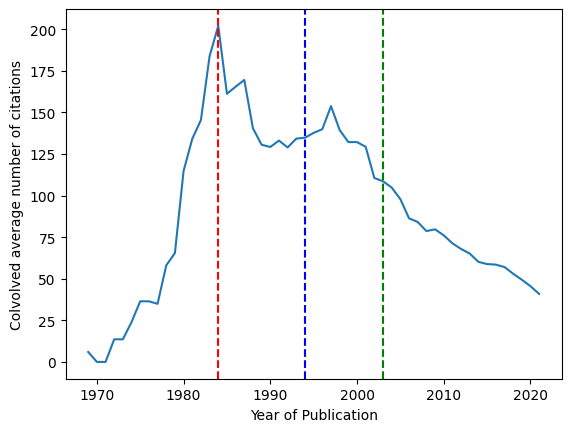

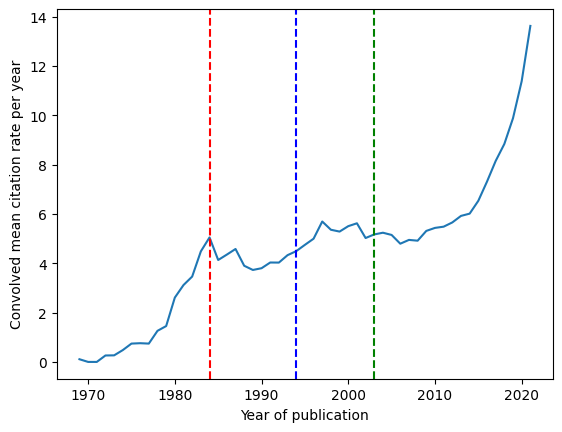

In [8]:
# find average number of citations per year
earliest = np.min(year_arr)
latest = np.max(year_arr)
total_citations_per_year = np.zeros(latest - earliest + 1)
num_works_per_year = np.zeros(latest - earliest + 1)
for i in range(abs_cite_arr.size):
    year = year_arr[i]
    citations = abs_cite_arr[i]
    total_citations_per_year[year - earliest] += citations
    num_works_per_year[year - earliest] += 1

avg_citations_per_year = total_citations_per_year / num_works_per_year
avg_citations_per_year = np.nan_to_num(avg_citations_per_year)

sweeping_avg = np.convolve(avg_citations_per_year, np.ones(5)/5, mode='valid')
sweeping_years = np.arange(earliest + 2, latest - 1)  # Years for the sweeping average

# correct for time published
# assume a linear rate of citations per year --> calculate mean citation Rate per year

sweeping_avg = np.convolve(avg_citations_per_year, np.ones(5)/5, mode='valid')
sweeping_years = np.arange(earliest + 2, latest - 1)  # Years for the sweeping average

plt.plot(sweeping_years, sweeping_avg)
plt.axvline(x=1984, color='red', linestyle='--')
plt.axvline(x=1994, color='blue', linestyle='--')
plt.axvline(x=2003, color='green', linestyle='--')

plt.xlabel("Year of Publication")
plt.ylabel("Colvolved average number of citations")
plt.savefig("num_cites_per_year_strings.png")
plt.show()

corrected_sweeping_avg = sweeping_avg / (2024 - sweeping_years)

plt.plot(sweeping_years, corrected_sweeping_avg)
plt.axvline(x=1984, color='red', linestyle='--')
plt.axvline(x=1994, color='blue', linestyle='--')
plt.axvline(x=2003, color='green', linestyle='--')
plt.xlabel("Year of publication")
plt.ylabel("Convolved mean citation rate per year")
plt.savefig("citation_rate_strings.png")
plt.show()